In [124]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import arviz as az

In [129]:
np.random.seed(12345)

x = np.linspace(0,8,100)

# Parameters for gaussian
alpha_true = 0.2
beta_true = 0.2
#noise
noise = stats.norm(loc=0,scale=0.02).rvs(size=len(x))

#Gaussian function
gauss = lambda x,alpha_true,beta_true: np.exp(-1*((alpha_true)*x+(beta_true)*x**2))
f = gauss(x=x,alpha_true=alpha_true, beta_true=beta_true)
f = f+noise
f_error = np.ones_like(f)*0.1*f.max()

a:  0.1594069245878383 std:  0.05243176468904224 
 b:  0.2243116076961672 std:  0.029997782954422906


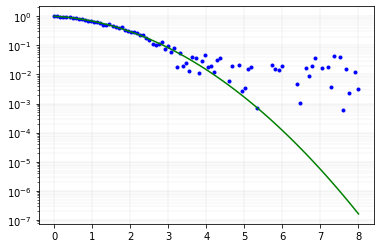

In [134]:
# non linear regression via scipy

def SFmodel(dose,alpha,beta,):
    expterm=(-1)*((alpha*dose)+(beta*dose**2))
    SF = np.exp(expterm)
    return SF

g=[0.4,0.4]
ng,cov=scipy.optimize.curve_fit(SFmodel,x,f,g,sigma=f_error, bounds=(0,np.inf),method="trf")
n=len(x)
sci_fit_y=np.empty(n)
for i in range(n):
    sci_fit_y[i]=SFmodel(x[i],ng[0],ng[1])
plt.yscale('log')
plt.plot(x,f, 'b.')
plt.grid(b=True, which='major', color='grey', linestyle='-', linewidth='0.1')
plt.grid(b=True, which='minor', color='grey', linestyle='--', linewidth='0.1')
plt.plot(sorted(x, reverse=True),sorted(sci_fit_y), 'g-')
print('a: ',ng[0],'std: ', stdevs[0], '\n', 'b: ', ng[1], 'std: ', stdevs[1] )

In [140]:
with pm.Model() as survival_fit_model:
    alpha = pm.Uniform('alpha', 0, 1, testval= 0.5)
    beta = pm.Uniform('beta', 0, 1, testval= 0.5)

    gauss=pm.Deterministic('gauss',np.exp(-1*((alpha)*x+(beta)*x**2)))

    y = pm.Normal('y', mu=gauss, tau=1.0/f_error**2, observed=f)

    start=pm.find_MAP()
    step=pm.NUTS()
    trace=pm.sample(5000,start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 58 seconds.
The number of effective samples is smaller than 10% for some parameters.


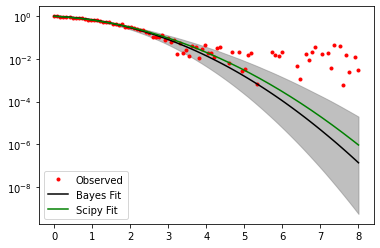

In [141]:
plt.yscale('log')
y_min = np.percentile(trace.gauss,1,axis=0)
y_max = np.percentile(trace.gauss,99,axis=0)
y_fit = np.percentile(trace.gauss,50,axis=0)

plt.plot(x,f, 'r', marker='.', ls='None', label='Observed')
plt.plot(x,y_fit,'k', marker='None', ls='-', ms=5, mew=1, label='Bayes Fit')
plt.plot(fitx, fity, 'g',marker='None', ls='-', ms=5, mew=1, label='Scipy Fit')
plt.fill_between(x, y_min, y_max, color='0.5', alpha=0.5)
plt.legend()

In [142]:
inference_data = az.from_pymc3(trace)

c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [143]:
az.summary(inference_data, var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.159,0.072,0.029,0.299,0.002,0.001,1941.0,1652.0,1887.0,1477.0,1.0
beta,0.228,0.044,0.147,0.311,0.001,0.001,1765.0,1765.0,1668.0,1075.0,1.0


c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\pymc3\plots\__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000243235880D0>,
      dtype=object)

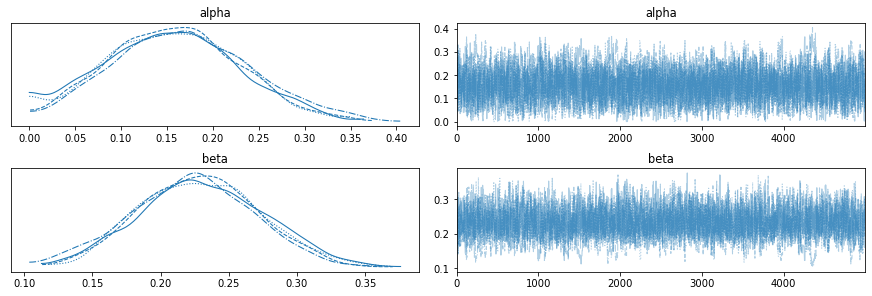

In [146]:
pm.traceplot(inference_data, varnames=["alpha", "beta"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024324B59E20>,
      dtype=object)

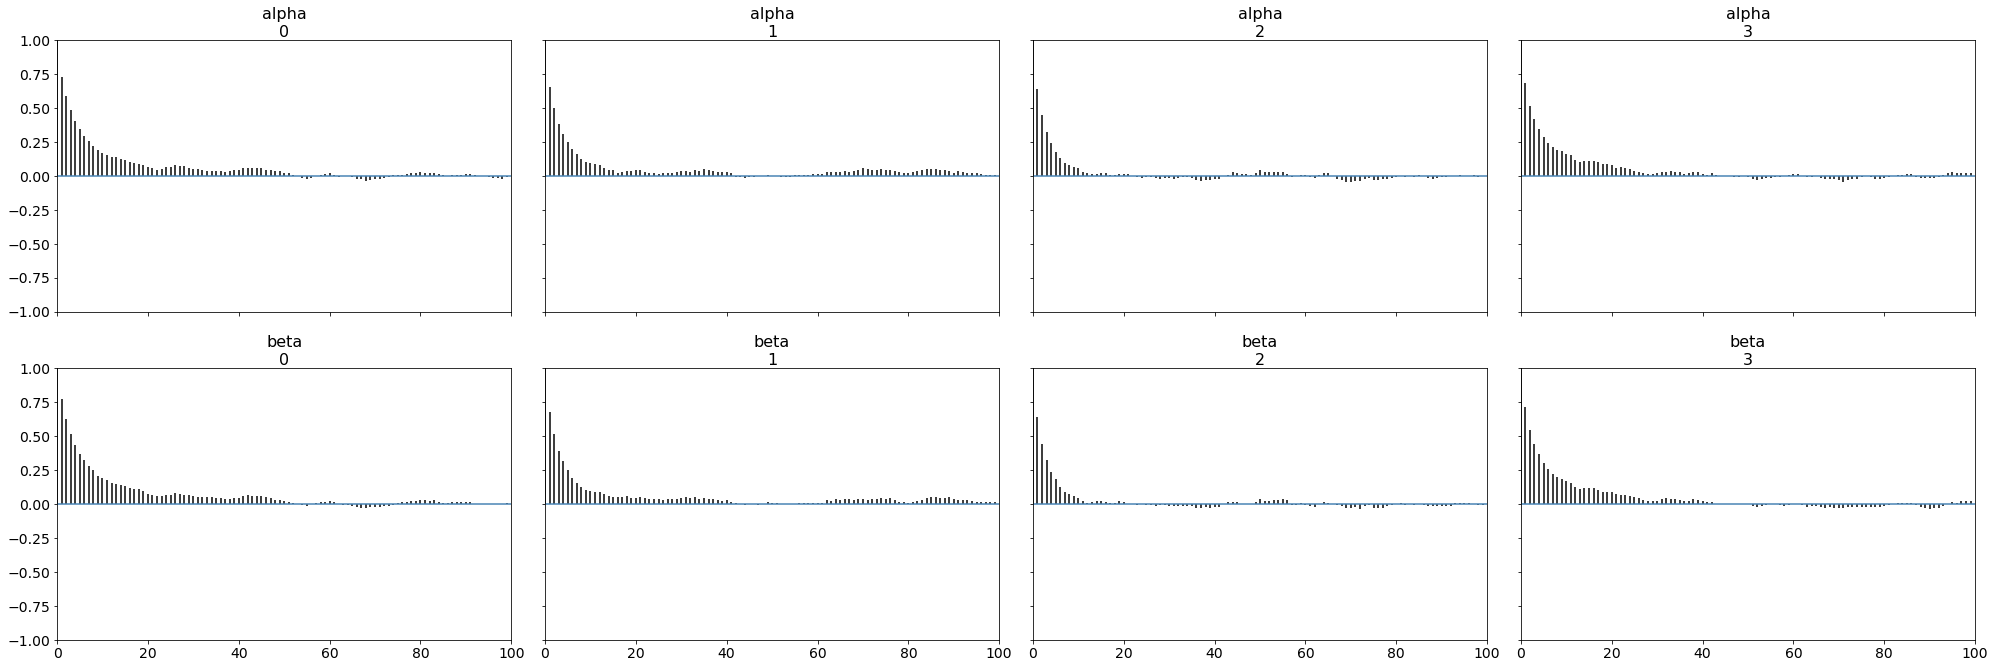

In [149]:
az.plot_autocorr(inference_data,var_names=("alpha", "beta"))

c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\pymc3\plots\__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024323A89580>,
      dtype=object)

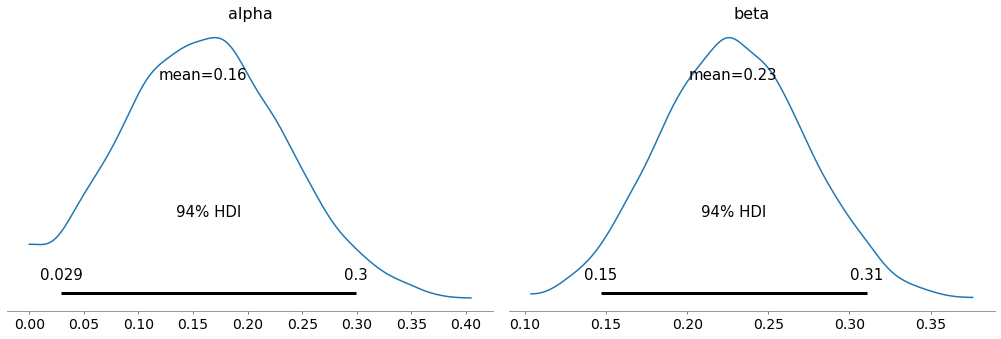

In [145]:
pm.plot_posterior(inference_data,varnames=["alpha", "beta"])
